In [1]:
import os

import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
from tensorflow.keras.optimizers import Adam
import mrcnn
from mrcnn import model as modellib
from mrcnn import config
from mrcnn import visualize

from skimage.io import imread
from skimage.transform import resize
import cv2
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Provide a central point to control graph sizes. 
#Change the default size attribute to control the size of plotted images.
def get_ax(rows=1, cols=1, size=8):
    
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### Brain Breast classifier

In [3]:
def f1score(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    precision = tp/(tp+fp+K.epsilon())
    recall = tp/(tp+fn+K.epsilon())
    f1 = 2*(precision*recall)/(precision+recall+K.epsilon())
    return K.mean(f1)

In [4]:
brain_breast_model= tf.keras.models.load_model(r'brain_breast_model.h5', custom_objects={'f1score': f1score}, compile=False)

In [5]:
# Prediction function
def predict_image_binary(model, img_path, labels=["Brain", "Breast"]):
    # Load image and convert to array
    img = imread(img_path)
    img= resize(img, (256, 256))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make prediction using the model
    prediction = model.predict(img_array)
    
    if prediction > 0.5:
        pred= labels[1]
    else:
        pred= labels[0]

    # plt.imshow(img_array[0])
    # plt.title("Predicted: "+ pred)

    # Return predicted label (0 or 1)
    return pred

### Brain classifier

In [6]:
brain_classifier= tf.keras.models.load_model('brain_classifier.h5', custom_objects={'Adam': Adam}, compile=False)

### Breast Classifier

In [9]:
breast_classifier= tf.keras.models.load_model('breast_classifier.h5', custom_objects={'Adam': Adam}, compile=False)

In [10]:
def predict_breast(image_path):
    img = imread(image_path)
    img= resize(img, (256, 256))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    pred= breast_classifier.predict(img_array)
    labels= ["Benign", "Malignant", "Normal"]
    
    return labels[np.argmax(pred)]

### Brain Segmentation

In [12]:
# Make a TestConfig class that extends our BrainConfig class but used for testing setting IMAGES_PER_GPU= 1
class TestConfig(config.Config):
    NAME= 'Test'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

test_config = TestConfig()
model_dir= os.getcwd()
# Recreate the model in inference mode
brain_segmentation = modellib.MaskRCNN(mode="inference", config=test_config, model_dir=model_dir)

# Get path to saved weights
model_path = r'mask_rcnn_brain.h5'

# Load trained weights and check if the path was empty srtring
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
brain_segmentation.load_weights(model_path, by_name=True)

Loading weights from  mask_rcnn_brain.h5


In [13]:
def load_image(image_path):
        # Read the image
        img = imread(image_path)
        # Resize the image to a specific size ((512,512) in our case)
        img = resize(img, (512,512), mode='constant', preserve_range=True)

        return img

In [21]:
def segment_brain(image_path):
    original_image= load_image(image_path)

    results = brain_segmentation.detect([original_image], verbose=0)
    r = results[0]
    masked_image= visualize.display_instance(original_image, r['rois'], r['masks'], r['class_ids'], scores= r['scores'], ax=get_ax())
    mask_bool = (r['masks'][:,:,0] == 1.0)
    rows, cols = np.where(mask_bool)
    min_row, min_col = np.min(rows), np.min(cols)
    max_row, max_col = np.max(rows), np.max(cols)
    width = max_col - min_col
    height = max_row - min_row
    print("Tumor width: ", width)
    print("Tumor height: ", height)
    return masked_image

### Breast Segmentation

In [15]:
breast_segmentation= tf.keras.models.load_model(r'unet_breast.h5', custom_objects={'Adam': Adam}, compile=False)

In [54]:
def segment_breast(breast_model , path):
  size = 256
  img = cv2.imread(path)
  img = img/255
  img = cv2.resize(img,(size,size))
  img_reshaped = img.reshape(1,size,size,3)

  pred_img = breast_model.predict(img_reshaped)
  pred_img = np.round(pred_img[0])
  segmented_img= np.array(pred_img, np.uint8)
  contours, _ = cv2.findContours(segmented_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Calculate the bounding box of the tumor
  x, y, w, h = cv2.boundingRect(contours[0])
  print("Tumor width: ", w)
  print("Tumor height: ", h)
  
  # Create a 3-channel version of the mask by replicating the single channel
  mask_3d = cv2.merge([pred_img*255, pred_img, pred_img])

  # Convert the mask to a float in the range 0 to 1
  mask_float = mask_3d.astype(float) / 255

  # Set the alpha value for the overlay
  alpha = 0.4

  # Perform the overlay operation
  overlay = cv2.addWeighted(img, 1-alpha, mask_float, alpha, 0)

  return overlay

### Full Predection function

In [55]:
def predection(image_path):
    result_img = imread(image_path)
    result= ""
    brain_breast= predict_image_binary(brain_breast_model, image_path)
    if brain_breast=="Brain":
        tumor_no_tumor= predict_image_binary(brain_classifier, image_path, ["No Tumor", "Tumor"])
        if tumor_no_tumor== "Tumor":
            result= "Brain Tumor"
            result_img= segment_brain(image_path)
        else:
            result= "Normal Brain"
    else:
        breast_classification= predict_breast(image_path)
        if breast_classification== "Normal":
            result= "Breast Normal"
        elif breast_classification== "Malignant":
            result_img= segment_breast(breast_segmentation, image_path)
            result= "Breast Malignant"
        else:
            result_img= segment_breast(breast_segmentation, image_path)
            result= "Breast Benign"
    plt.imshow(result_img)
    plt.title(result)

Tumor width:  144
Tumor height:  121


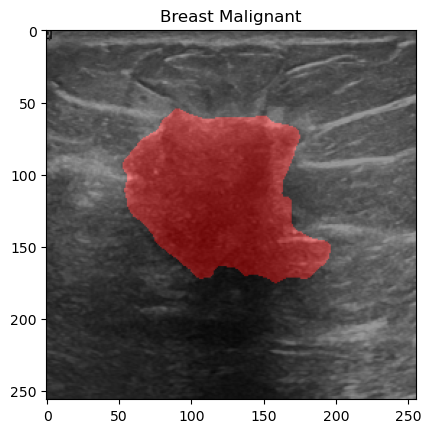

: 

In [57]:
predection(r'D:\ITI\Computer vision\Dataset\Breast scans\malignant\Test\malignant (195).png')

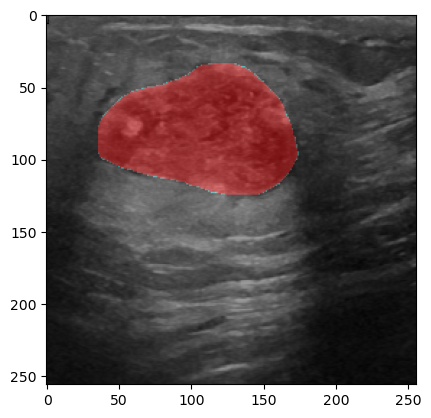

In [92]:
size = 256
img = cv2.imread(r'D:\ITI\Computer vision\Dataset\Breast scans\benign\Test\benign (403).png')
img = img/255
img = cv2.resize(img,(size,size))
img_reshaped = img.reshape(1,size,size,3)
pred_img = cv2.imread(r'D:\ITI\Computer vision\Dataset\Breast scans\benign\Test\benign (403)_mask.png')
pred_img= pred_img[:,:,0]
pred_img = cv2.resize(pred_img,(size,size))
pred_img = np.round(pred_img)
# Create a 3-channel version of the mask by replicating the single channel
mask_3d = cv2.merge([pred_img, pred_img*255, pred_img*255])
# Convert the mask to a float in the range 0 to 1
mask_float = mask_3d.astype(float) / 255
# Set the alpha value for the overlay
alpha = 0.4
# Perform the overlay operation
overlay = cv2.addWeighted(img, 1-alpha, mask_float, alpha, 0)
plt.imshow(overlay)